In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

Cosas a estudiar

In [ ]:
# Valor medio de respuesta vs. amplitud de alimentacion
# Valor medio de respuesta vs. offset de alimentacion
# Amplitud de respuesta vs. amplitud de alimentacion
# Amplitud de respuesta vs. offset de alimentacion
# frecuencia de respuesta vs. frecuencia de alimentacion

In [2]:
# Cargamos los datos
with open(f"../mediciones/Barrido en offsets a 0.2 V de amp.pickle", "rb") as f:
    dic = pickle.load(f)

In [39]:
# Hago una lista con los valores de offset que alimentamos con el generador de funciones
offs_values = list(dic.keys())
print(offs_values)
# Valores de corriente en mA
corr_values = [np.mean(dic[offset]["V_2"])*1000 for offset in offs_values]
print(corr_values)

['0.0V', '0.25V', '0.5V', '0.75V', '1.0V', '1.25V', '1.5V', '1.75V', '2.0V', '2.25V', '2.5V', '2.75V', '3.0V', '3.25V', '3.5V']
[-360.99199999999996, -357.8399999999999, -354.2559999999999, -350.06399999999996, -344.29599999999994, -339.9679999999999, -333.61599999999993, -327.4239999999999, -320.40799999999996, -311.82399999999996, -301.4479999999999, -290.17599999999993, -273.89599999999996, 4.5600000000000005, 2.9600000000000004]


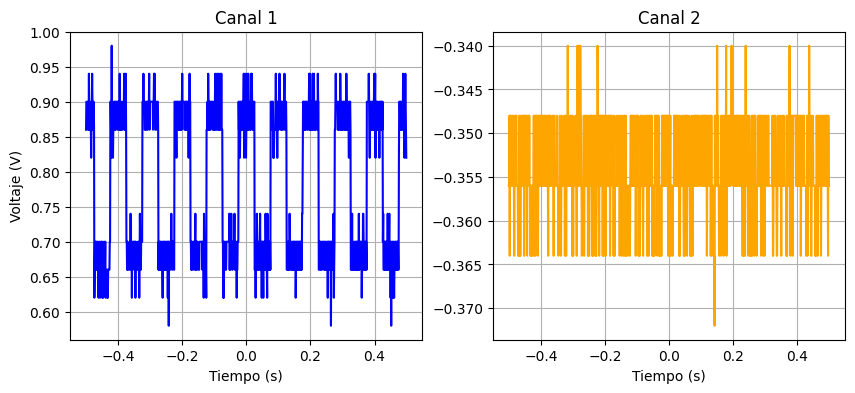

In [12]:
volt = offs_values[2]

t_1, v_1 = dic[volt]["t_1"], dic[volt]["V_1"]
t_2, v_2 = dic[volt]["t_2"], dic[volt]["V_2"]


fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
axs[0].plot(t_1,v_1, color = "b")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(t_2,v_2, color = "orange")
axs[1].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Voltaje (V)")
axs[0].set_title("Canal 1")
axs[0].grid()
axs[1].set_title("Canal 2")
axs[1].grid()
plt.show()

# Relación entre offset seteado y offset medido

In [31]:
offs_true_values = [np.mean(dic[offset]["V_1"]) for offset in offs_values]

offs_values_new = []
for offset in offs_values:
    if len(offset) == 4:
        new_offset = offset[0:3]
    else:
        new_offset = offset[0:4]
    offs_values_new.append(float(new_offset))

print(offs_values_new)

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]


In [45]:
def lineal(x, a, b): return a*x+b

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(lineal, offs_values_new, offs_true_values)

# Imprimo en pantalla los valores de popt y pcov
a, b = popt
err_a, err_b = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'a: {a} ± {err_a}')
print(f'b: {b} ± {err_b}')

Los parametros de ajuste son:
a: 2.0205468569658125 ± 0.0032979893578391224
b: -0.23094899954094106 ± 0.006782294541937294


Hay diferencias recién en la 3ra y 4ta cifra significativa.

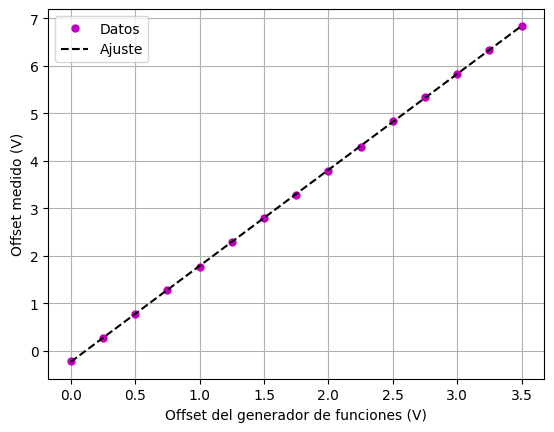

In [46]:
plt.plot(offs_values_new, offs_true_values, ".m",ms = 10, label = "Datos")
plt.plot(offs_values_new, lineal(np.array(offs_values_new),a,b), "--k", label = "Ajuste")
plt.xlabel("Offset del generador de funciones (V)")
plt.ylabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()

# Relación entre offset de la alimentación y valor medio de corriente medido

In [56]:
# Ajuste cuadrático
def cuad(x, A, B, C): return A*x**2 + B*x + C

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(cuad, offs_true_values[:-2], corr_values[:-2])

# Imprimo en pantalla los valores de popt y pcov
A, B, C = popt
err_A, err_B, err_C = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'A: {A} ± {err_A}')
print(f'B: {B} ± {err_B}')
print(f'C: {C} ± {err_C}')

Los parametros de ajuste son:
A: 1.7173686502553398 ± 0.15450967624531345
B: 3.9068628983127716 ± 0.9067617027204466
C: -358.7263768385672 ± 1.1009477023938665


In [57]:
# Ajuste exponencial
def exp(x, Amp, frec, ord): return Amp*np.exp(frec*x) + ord

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(exp, offs_true_values[:-2], corr_values[:-2])

# Imprimo en pantalla los valores de popt y pcov
Amp, frec, ord = popt
err_Amp, err_frec, err_ord = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'Amp: {Amp} ± {err_Amp}')
print(f'frec: {frec} ± {err_frec}')
print(f'ord: {ord} ± {err_ord}')

Los parametros de ajuste son:
Amp: 22.084582702710563 ± 2.2508955340992407
frec: 0.2679117668271102 ± 0.013934067016884126
ord: -381.189949218603 ± 2.7053965549731505


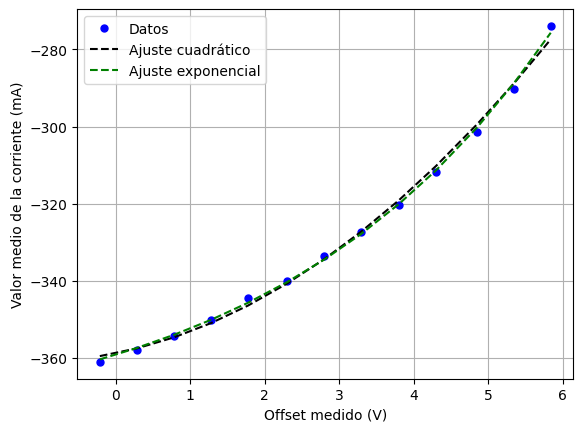

In [64]:
plt.plot(offs_true_values[:-2], corr_values[:-2],".b", ms = 10, label = "Datos")
#plt.plot(offs_true_values[:], corr_values[:],".b", ms = 10, label = "Datos")
plt.plot(offs_true_values[:-2], cuad(np.array(offs_true_values[:-2]),A,B,C), "--k", label = "Ajuste cuadrático")
plt.plot(offs_true_values[:-2], exp(np.array(offs_true_values[:-2]),Amp,frec,ord), "--g", label = "Ajuste exponencial")
plt.ylabel("Valor medio de la corriente (mA)")
plt.xlabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()